# Power Patterns, thinkonward.com

This notebook is a submission to Onward's challenge [Power Patterns: Harnessing Electricity for Innovation](https://thinkonward.com/app/c/challenges/power-patterns).

It's proposal is simple: convert the 1-dimensional data of energy consumption over time into a 2-dimensional histogram representing likelihood of energy draw in a one-day period, and cluster profiles one the resulting surfaces.

The Notebook is in 3 parts:

1. load and process data
2. run through clustering algorithm
3. examine cluster properties

The motivation for this methodology is based on two hypotheses that Demand Response programs are less interested the average power consumptions of a building and more so about how _shiftable_ this consumption is.

The reasoning is that buildings with the most variable demand (i.e. very flat distributions) are the ones with the activities that do not need to happen on particular schedules. They'll respond well to responsive Demand Response programs that vary according to the energy grid's needs.

Buildings with predictable demand most likely have activities that must happen on a pre-determined basis. These consumers would respond better to static Demand Response programs known well in advance. This would let them find alternative power sources or make plans for changing their consumption.

The analysis in this notebook finds there is no clear distinction between clusters made based on predictability of demand, but it does show that this metric does allow for a clear distinction between groups made.

# 1. Load and Prepare Data

Processing the data does the following:

- group energy consumption data by 30 minute time step
- normalize each group so that the minimum energy consumption is 0 and the maximum is 1
- create a normalized histogram of each tim step showing the distribution of energy consumption
- collate these histograms to create a 2-D histogram of energy consumption in a day

In [20]:
LOAD_ORIGINAL_DATA = False
STASH_PROCESSED_DATA = True

In [21]:
import numpy as np
import json
from tqdm.notebook import tqdm
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from utils import load_data, make_heatmap, smooth_heatmap


if LOAD_ORIGINAL_DATA:
    print("Loading raw data...")
    energy_data = load_data()

    print("Pre-processing data...")
    N_BINS = 48

    power_profiles = np.zeros((len(energy_data.columns), N_BINS, N_BINS))
    lookup = {}
    for i, col in tqdm(enumerate(energy_data.columns), total=len(energy_data.columns)):
        lookup[col] = i
        heatmap = make_heatmap(energy_data[col], N_BINS, '30min')
        smoothed = smooth_heatmap(heatmap)
        normalized = smoothed / smoothed.max().max()
        scaled = TimeSeriesScalerMeanVariance().fit_transform(normalized.values)
        power_profiles[i, :, :] = normalized.values

        if STASH_PROCESSED_DATA:
            json.dump(lookup, open('processed/lookup.json', 'w'))
            np.save(f'processed/{i}.npy', normalized.values)
else:
    print('Skipping pre-processing step')

Skipping pre-processing step


In [22]:
SHAPE = (1277, 48, 48)

if not LOAD_ORIGINAL_DATA:
    print("Loading pre-processed data...")
    lookup = json.load(open('processed/lookup.json'))
    power_profiles = np.zeros(SHAPE)
    for i in tqdm(range(SHAPE[0])):
        power_profiles[i, :, :] = np.load(f'tmp/processed/{i}.npy')


Loading pre-processed data...


  0%|          | 0/1277 [00:00<?, ?it/s]

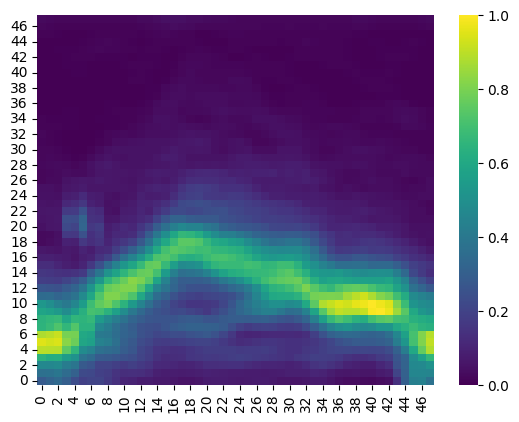

In [23]:
from utils import plot_heatmap


bu_id = '922'

profile = power_profiles[lookup[bu_id], :, :]
plot_heatmap(profile)

# 2. Cluster

In [24]:
from tslearn.clustering import KShape

ITER_CLUSTERS = 8

inertia = []
for i in tqdm(range(1, ITER_CLUSTERS+1)):
    ks = KShape(n_clusters=i, n_init=10)
    ks.fit(power_profiles)
    inertia.append(ks.inertia_)

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'Inertia')

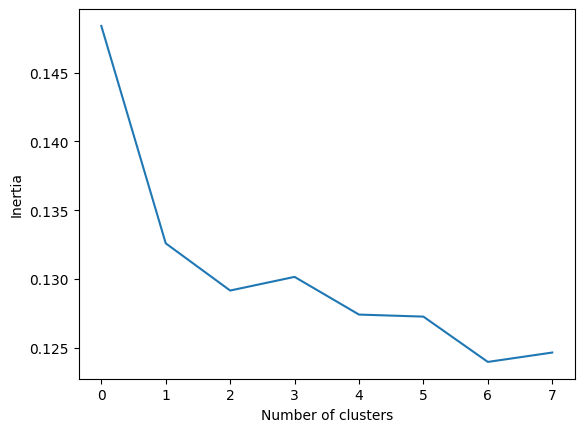

In [25]:
import matplotlib.pyplot as plt

plt.plot(inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [26]:
# The above elbow plot suggests that 3 clusters is a good choice

N_CLUSTERS = 3

ks = KShape(n_clusters=N_CLUSTERS, n_init=10)
ks.fit_predict(power_profiles)

import pandas as pd

labels = pd.Series(ks.labels_)
labels.value_counts()

2    490
0    433
1    354
Name: count, dtype: int64

<Axes: >

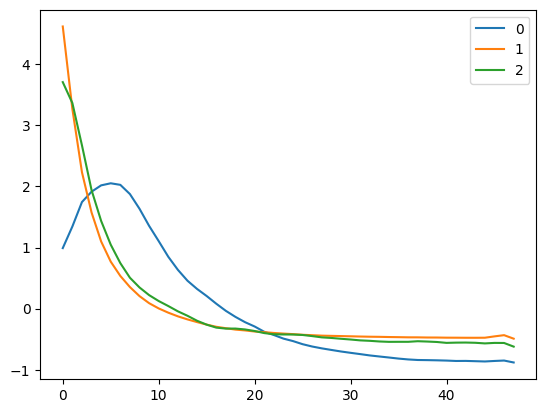

In [27]:
centers = pd.DataFrame(ks.cluster_centers_[:, :, 0].T)
centers.plot()

# 3. Examine Cluster Properties

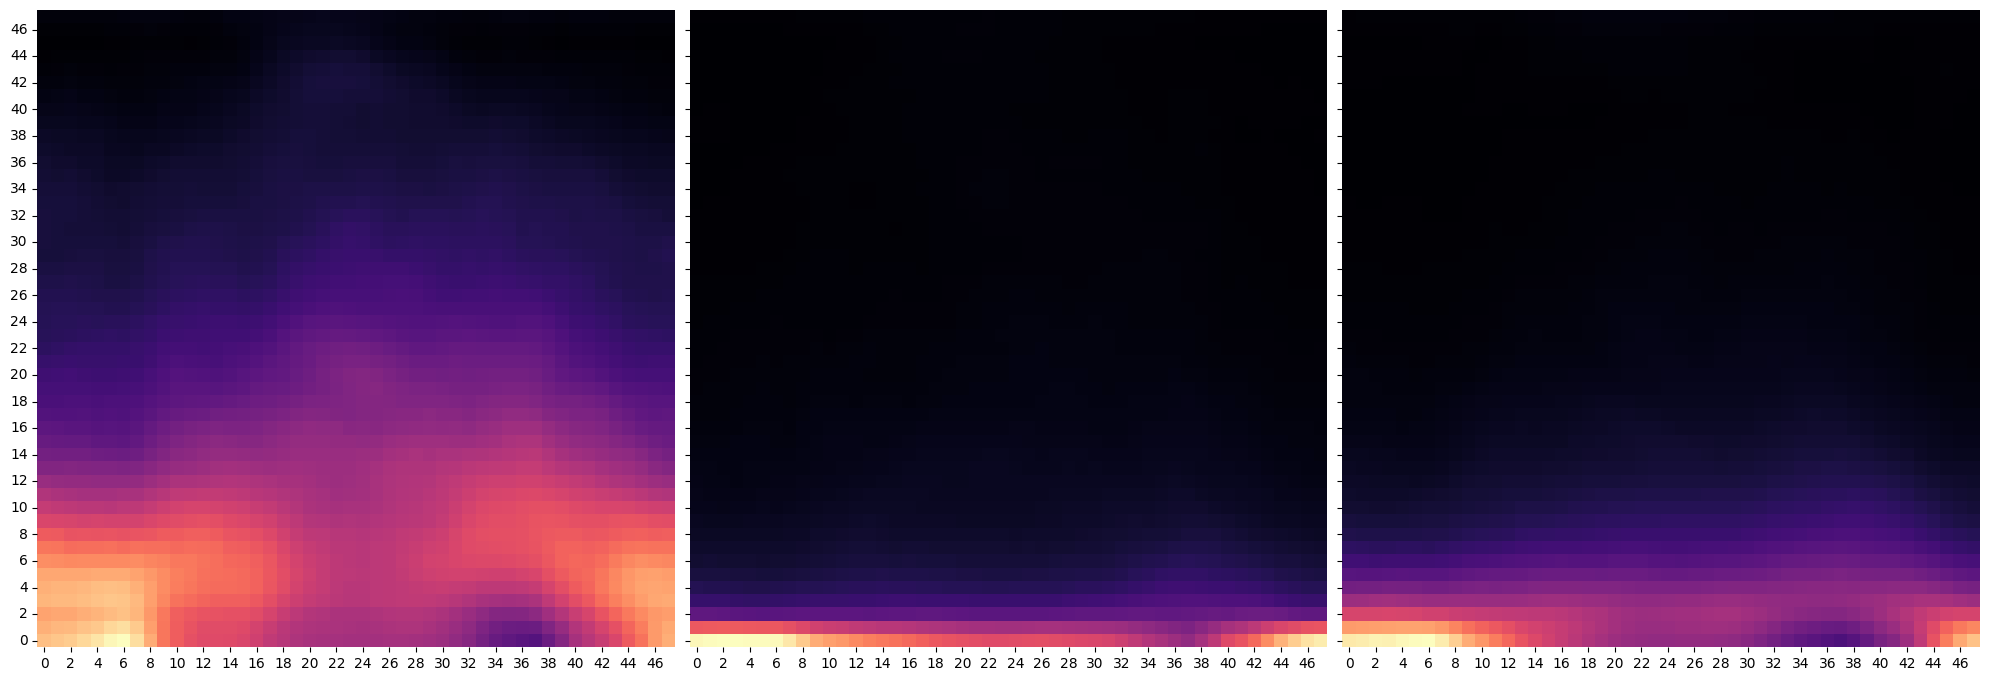

In [28]:
# What is the mean heatmap of each cluster?

import seaborn as sns

fig, ax = plt.subplots(
    ncols=N_CLUSTERS,
    sharex=True, sharey=True,
    figsize=(20, 40),
    subplot_kw=dict(box_aspect=1),
    layout='tight',
)

for label in range(N_CLUSTERS):
    indexes = labels[labels == label].index
    mean_heatmap = np.mean(power_profiles[indexes, :, :], axis=0)
    sns.heatmap(mean_heatmap, cmap='magma', ax=ax[label], cbar=False)
    ax[label].invert_yaxis()

To evaluate the quality of the clusters we extract two further characteristics:
- the highest probability at each time step of the heatmap
- the value associated with this probability

These tell us in general which cluster is the most predictable by looking at which has the highest maximums of probabilities and which is most likely to be consuming higher amounts of power during the day.

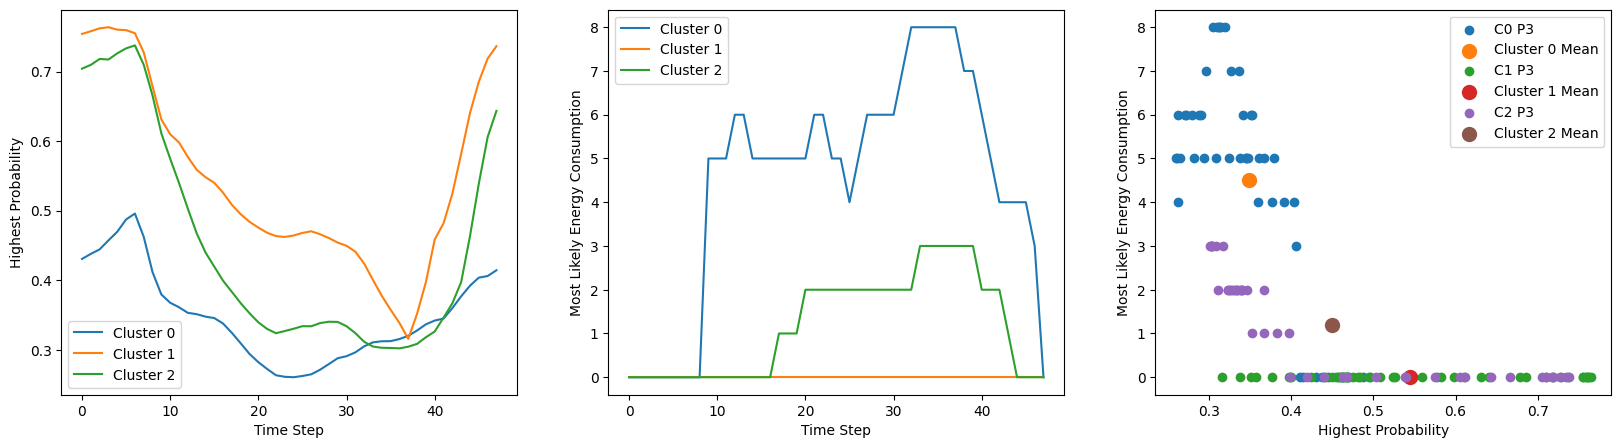

In [29]:
def plot_charts(random_sample=False):
    fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
    scores = {}

    for label in range(N_CLUSTERS):
        if random_sample:
            indexes = labels.sample(100).index
        else:
            indexes = labels[labels == label].index
        mean_heatmap = np.mean(power_profiles[indexes, :, :], axis=0)
        prop_1 = np.max(mean_heatmap, axis=0)
        ax[0].plot(prop_1, label=f'Cluster {label}')
        prop_2 = np.argmax(mean_heatmap, axis=0)
        ax[1].plot(prop_2, label=f'Cluster {label}')
        ax[2].scatter(prop_1, prop_2, label=f'C{label} P3')
        mean_prop_1 = np.mean(prop_1)
        mean_prop_2 = np.mean(prop_2)
        ax[2].scatter(mean_prop_1, mean_prop_2, label=f'Cluster {label} Mean', s=100)
        if mean_prop_1 == 0:
            scores[label] = 1
        scores[label] = np.arctan(mean_prop_2/mean_prop_1)

    ax[0].set_ylabel('Highest Probability')
    ax[0].set_xlabel('Time Step')
    ax[1].set_ylabel('Most Likely Energy Consumption')
    ax[1].set_xlabel('Time Step')
    ax[2].set_ylabel('Most Likely Energy Consumption')
    ax[2].set_xlabel('Highest Probability')
    for axi in ax:
        axi.legend()
    return scores

scores = plot_charts()

In [30]:
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print('Flexibility scores:')
for cluster, score in sorted_scores:
    print(f'    Cluster {cluster} -> {score:.2f}')

Flexibility scores:
    Cluster 0 -> 1.49
    Cluster 2 -> 1.21
    Cluster 1 -> 0.00


{0: 0.7082512143128195, 1: 0.3706830757075239, 2: 0.7432057534161782}

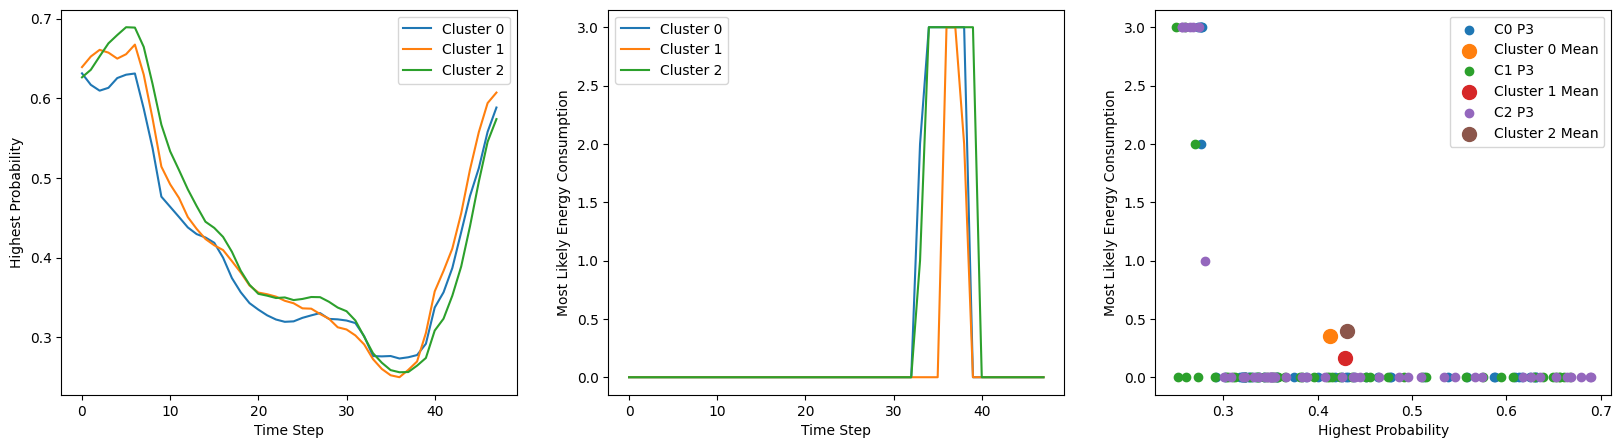

In [31]:
# Compare the above graphs to those made by a random sample of
# 100 buildings
plot_charts(random_sample=True)

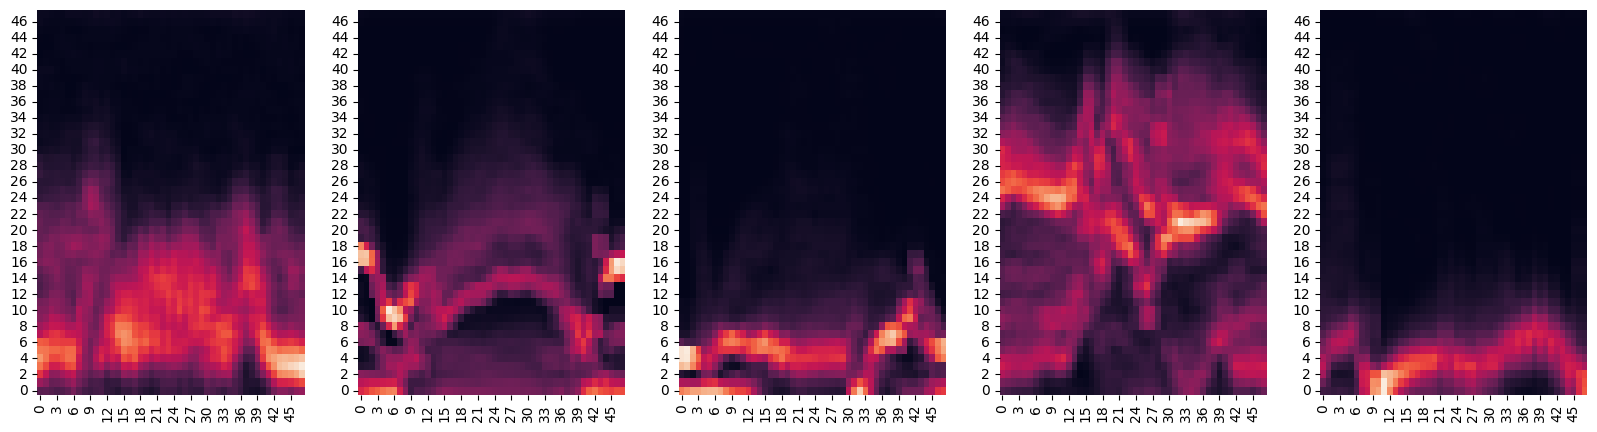

In [32]:
least_predictable = sorted_scores[0][0]

SAMPLE = 5
fig, ax = plt.subplots(ncols=SAMPLE, figsize=(20, 5))

indexes = labels[labels == least_predictable].sample(SAMPLE).index
for i, index in enumerate(indexes):
    sns.heatmap(power_profiles[index, :, :], ax=ax[i], cbar=False)
    ax[i].invert_yaxis()


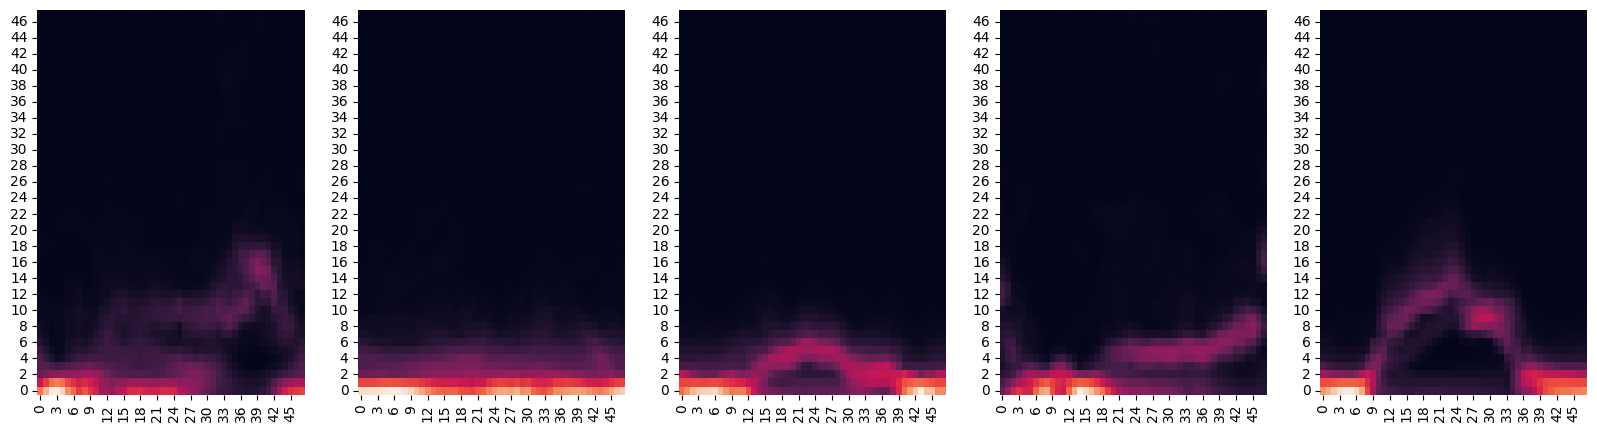

In [33]:
most_predictable = sorted_scores[-1][0]

fig, ax = plt.subplots(ncols=SAMPLE, figsize=(20, 5))

indexes = labels[labels == most_predictable].sample(SAMPLE).index
for i, index in enumerate(indexes):
    sns.heatmap(power_profiles[index, :, :], ax=ax[i], cbar=False)
    ax[i].invert_yaxis()

# Conclusion


This notebook proposes a relatively small change to otherwise straightforward approach of K-Means clustering. By converting the power profile of a building into a 2-D heatmap, it allows for a new view on how to cluster the different power profiles and interpret the results.

Further work would compare this clustering approach to other methodologies. In particular a fuzzy clustering method may be well suited considering that there is no clear distinction between the groups.

